In [19]:
!pip install ftfy

In [34]:
import torch
from torch.utils.data import Dataset, DataLoader
import json
from PIL import Image
import os
import hashlib
import urllib
import warnings
from packaging import version
from typing import Union, List , Tuple
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from tqdm import tqdm
from collections import OrderedDict
import numpy as np
import torch.nn.functional as F
from torch import nn
import gzip
import html
from functools import lru_cache
import ftfy
import regex as re
from IPython.display import display


try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC


if version.parse(torch.__version__) < version.parse("1.7.1"):
    warnings.warn("PyTorch version 1.7.1 or higher is recommended")


# **CLIP Model Methods:**

**MODEL CODE:**

In [21]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()

        # all conv layers have stride 1. an avgpool is performed after the second convolution when stride > 1
        self.conv1 = nn.Conv2d(inplanes, planes, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)

        self.avgpool = nn.AvgPool2d(stride) if stride > 1 else nn.Identity()

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu3 = nn.ReLU(inplace=True)

        self.downsample = None
        self.stride = stride

        if stride > 1 or inplanes != planes * Bottleneck.expansion:
            # downsampling layer is prepended with an avgpool, and the subsequent convolution has stride 1
            self.downsample = nn.Sequential(OrderedDict([
                ("-1", nn.AvgPool2d(stride)),
                ("0", nn.Conv2d(inplanes, planes * self.expansion, 1, stride=1, bias=False)),
                ("1", nn.BatchNorm2d(planes * self.expansion))
            ]))

    def forward(self, x: torch.Tensor):
        identity = x

        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.relu2(self.bn2(self.conv2(out)))
        out = self.avgpool(out)
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu3(out)
        return out


class AttentionPool2d(nn.Module):
    def __init__(self, spacial_dim: int, embed_dim: int, num_heads: int, output_dim: int = None):
        super().__init__()
        self.positional_embedding = nn.Parameter(torch.randn(spacial_dim ** 2 + 1, embed_dim) / embed_dim ** 0.5)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, output_dim or embed_dim)
        self.num_heads = num_heads

    def forward(self, x):
        x = x.flatten(start_dim=2).permute(2, 0, 1)  # NCHW -> (HW)NC
        x = torch.cat([x.mean(dim=0, keepdim=True), x], dim=0)  # (HW+1)NC
        x = x + self.positional_embedding[:, None, :].to(x.dtype)  # (HW+1)NC
        x, _ = F.multi_head_attention_forward(
            query=x[:1], key=x, value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=None,
            in_proj_bias=torch.cat([self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]),
            bias_k=None,
            bias_v=None,
            add_zero_attn=False,
            dropout_p=0,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            use_separate_proj_weight=True,
            training=self.training,
            need_weights=False
        )
        return x.squeeze(0)


class ModifiedResNet(nn.Module):
    """
    A ResNet class that is similar to torchvision's but contains the following changes:
    - There are now 3 "stem" convolutions as opposed to 1, with an average pool instead of a max pool.
    - Performs anti-aliasing strided convolutions, where an avgpool is prepended to convolutions with stride > 1
    - The final pooling layer is a QKV attention instead of an average pool
    """

    def __init__(self, layers, output_dim, heads, input_resolution=224, width=64):
        super().__init__()
        self.output_dim = output_dim
        self.input_resolution = input_resolution

        # the 3-layer stem
        self.conv1 = nn.Conv2d(3, width // 2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width // 2)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(width // 2, width // 2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(width // 2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(width // 2, width, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(width)
        self.relu3 = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(2)

        # residual layers
        self._inplanes = width  # this is a *mutable* variable used during construction
        self.layer1 = self._make_layer(width, layers[0])
        self.layer2 = self._make_layer(width * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(width * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(width * 8, layers[3], stride=2)

        embed_dim = width * 32  # the ResNet feature dimension
        self.attnpool = AttentionPool2d(input_resolution // 32, embed_dim, heads, output_dim)

    def _make_layer(self, planes, blocks, stride=1):
        layers = [Bottleneck(self._inplanes, planes, stride)]

        self._inplanes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self._inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        def stem(x):
            x = self.relu1(self.bn1(self.conv1(x)))
            x = self.relu2(self.bn2(self.conv2(x)))
            x = self.relu3(self.bn3(self.conv3(x)))
            x = self.avgpool(x)
            return x

        x = x.type(self.conv1.weight.dtype)
        x = stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.attnpool(x)

        return x


class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)


class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None):
        super().__init__()

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

    def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

    def forward(self, x: torch.Tensor):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int, attn_mask: torch.Tensor = None):
        super().__init__()
        self.width = width
        self.layers = layers
        self.resblocks = nn.Sequential(*[ResidualAttentionBlock(width, heads, attn_mask) for _ in range(layers)])

    def forward(self, x: torch.Tensor):
        return self.resblocks(x)


class VisionTransformer(nn.Module):
    def __init__(self, input_resolution: int, patch_size: int, width: int, layers: int, heads: int, output_dim: int):
        super().__init__()
        self.input_resolution = input_resolution
        self.output_dim = output_dim
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=patch_size, bias=False)

        scale = width ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(width))
        self.positional_embedding = nn.Parameter(scale * torch.randn((input_resolution // patch_size) ** 2 + 1, width))
        self.ln_pre = LayerNorm(width)

        self.transformer = Transformer(width, layers, heads)

        self.ln_post = LayerNorm(width)
        self.proj = nn.Parameter(scale * torch.randn(width, output_dim))

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)  # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)

        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD

        x = self.ln_post(x[:, 0, :])

        if self.proj is not None:
            x = x @ self.proj

        return x


class CLIP(nn.Module):
    def __init__(self,
                 embed_dim: int,
                 # vision
                 image_resolution: int,
                 vision_layers: Union[Tuple[int, int, int, int], int],
                 vision_width: int,
                 vision_patch_size: int,
                 # text
                 context_length: int,
                 vocab_size: int,
                 transformer_width: int,
                 transformer_heads: int,
                 transformer_layers: int
                 ):
        super().__init__()

        self.context_length = context_length

        if isinstance(vision_layers, (tuple, list)):
            vision_heads = vision_width * 32 // 64
            self.visual = ModifiedResNet(
                layers=vision_layers,
                output_dim=embed_dim,
                heads=vision_heads,
                input_resolution=image_resolution,
                width=vision_width
            )
        else:
            vision_heads = vision_width // 64
            self.visual = VisionTransformer(
                input_resolution=image_resolution,
                patch_size=vision_patch_size,
                width=vision_width,
                layers=vision_layers,
                heads=vision_heads,
                output_dim=embed_dim
            )

        self.transformer = Transformer(
            width=transformer_width,
            layers=transformer_layers,
            heads=transformer_heads,
            attn_mask=self.build_attention_mask()
        )

        self.vocab_size = vocab_size
        self.token_embedding = nn.Embedding(vocab_size, transformer_width)
        self.positional_embedding = nn.Parameter(torch.empty(self.context_length, transformer_width))
        self.ln_final = LayerNorm(transformer_width)

        self.text_projection = nn.Parameter(torch.empty(transformer_width, embed_dim))
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.initialize_parameters()

    def initialize_parameters(self):
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.01)

        if isinstance(self.visual, ModifiedResNet):
            if self.visual.attnpool is not None:
                std = self.visual.attnpool.c_proj.in_features ** -0.5
                nn.init.normal_(self.visual.attnpool.q_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.k_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.v_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.c_proj.weight, std=std)

            for resnet_block in [self.visual.layer1, self.visual.layer2, self.visual.layer3, self.visual.layer4]:
                for name, param in resnet_block.named_parameters():
                    if name.endswith("bn3.weight"):
                        nn.init.zeros_(param)

        proj_std = (self.transformer.width ** -0.5) * ((2 * self.transformer.layers) ** -0.5)
        attn_std = self.transformer.width ** -0.5
        fc_std = (2 * self.transformer.width) ** -0.5
        for block in self.transformer.resblocks:
            nn.init.normal_(block.attn.in_proj_weight, std=attn_std)
            nn.init.normal_(block.attn.out_proj.weight, std=proj_std)
            nn.init.normal_(block.mlp.c_fc.weight, std=fc_std)
            nn.init.normal_(block.mlp.c_proj.weight, std=proj_std)

        if self.text_projection is not None:
            nn.init.normal_(self.text_projection, std=self.transformer.width ** -0.5)

    def build_attention_mask(self):
        # lazily create causal attention mask, with full attention between the vision tokens
        # pytorch uses additive attention mask; fill with -inf
        mask = torch.empty(self.context_length, self.context_length)
        mask.fill_(float("-inf"))
        mask.triu_(1)  # zero out the lower diagonal
        return mask

    @property
    def dtype(self):
        return self.visual.conv1.weight.dtype

    def encode_image(self, image):
        return self.visual(image.type(self.dtype))

    def encode_text(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x

    def forward(self, image, text):
        image_features = self.encode_image(image)
        text_features = self.encode_text(text)

        # normalized features
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()

        # shape = [global_batch_size, global_batch_size]
        return logits_per_image, logits_per_text


def convert_weights(model: nn.Module):
    """Convert applicable model parameters to fp16"""

    def _convert_weights_to_fp16(l):
        if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Linear)):
            l.weight.data = l.weight.data.half()
            if l.bias is not None:
                l.bias.data = l.bias.data.half()

        if isinstance(l, nn.MultiheadAttention):
            for attr in [*[f"{s}_proj_weight" for s in ["in", "q", "k", "v"]], "in_proj_bias", "bias_k", "bias_v"]:
                tensor = getattr(l, attr)
                if tensor is not None:
                    tensor.data = tensor.data.half()

        for name in ["text_projection", "proj"]:
            if hasattr(l, name):
                attr = getattr(l, name)
                if attr is not None:
                    attr.data = attr.data.half()

    model.apply(_convert_weights_to_fp16)


def build_model(state_dict: dict):
    vit = "visual.proj" in state_dict

    if vit:
        vision_width = state_dict["visual.conv1.weight"].shape[0]
        vision_layers = len([k for k in state_dict.keys() if k.startswith("visual.") and k.endswith(".attn.in_proj_weight")])
        vision_patch_size = state_dict["visual.conv1.weight"].shape[-1]
        grid_size = round((state_dict["visual.positional_embedding"].shape[0] - 1) ** 0.5)
        image_resolution = vision_patch_size * grid_size
    else:
        counts: list = [len(set(k.split(".")[2] for k in state_dict if k.startswith(f"visual.layer{b}"))) for b in [1, 2, 3, 4]]
        vision_layers = tuple(counts)
        vision_width = state_dict["visual.layer1.0.conv1.weight"].shape[0]
        output_width = round((state_dict["visual.attnpool.positional_embedding"].shape[0] - 1) ** 0.5)
        vision_patch_size = None
        assert output_width ** 2 + 1 == state_dict["visual.attnpool.positional_embedding"].shape[0]
        image_resolution = output_width * 32

    embed_dim = state_dict["text_projection"].shape[1]
    context_length = state_dict["positional_embedding"].shape[0]
    vocab_size = state_dict["token_embedding.weight"].shape[0]
    transformer_width = state_dict["ln_final.weight"].shape[0]
    transformer_heads = transformer_width // 64
    transformer_layers = len(set(k.split(".")[2] for k in state_dict if k.startswith("transformer.resblocks")))

    model = CLIP(
        embed_dim,
        image_resolution, vision_layers, vision_width, vision_patch_size,
        context_length, vocab_size, transformer_width, transformer_heads, transformer_layers
    )

    for key in ["input_resolution", "context_length", "vocab_size"]:
        if key in state_dict:
            del state_dict[key]

    convert_weights(model)
    model.load_state_dict(state_dict)
    return model.eval()

**TOKENIZER CODE:**

In [22]:
File_directory="/kaggle/input/bpe-simple-vocab-16e6-txt-zip"
@lru_cache()
def default_bpe():
    return os.path.join(File_directory,"bpe_simple_vocab_16e6.txt")


@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()


def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = default_bpe()):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
          # Open and read the BPE file correctly
        with open(bpe_path, "r", encoding="utf-8") as file:
            merges = file.read().split('\n')
#          merges = (bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text

**CLIP MODEL METHODS:**

In [23]:
__all__ = ["available_models", "load", "tokenize"]
_tokenizer = SimpleTokenizer()

_MODELS = {
    "RN50": "https://openaipublic.azureedge.net/clip/models/afeb0e10f9e5a86da6080e35cf09123aca3b358a0c3e3b6c78a7b63bc04b6762/RN50.pt",
    "RN101": "https://openaipublic.azureedge.net/clip/models/8fa8567bab74a42d41c5915025a8e4538c3bdbe8804a470a72f30b0d94fab599/RN101.pt",
    "RN50x4": "https://openaipublic.azureedge.net/clip/models/7e526bd135e493cef0776de27d5f42653e6b4c8bf9e0f653bb11773263205fdd/RN50x4.pt",
    "RN50x16": "https://openaipublic.azureedge.net/clip/models/52378b407f34354e150460fe41077663dd5b39c54cd0bfd2b27167a4a06ec9aa/RN50x16.pt",
    "RN50x64": "https://openaipublic.azureedge.net/clip/models/be1cfb55d75a9666199fb2206c106743da0f6468c9d327f3e0d0a543a9919d9c/RN50x64.pt",
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
    "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
    "ViT-L/14@336px": "https://openaipublic.azureedge.net/clip/models/3035c92b350959924f9f00213499208652fc7ea050643e8b385c2dac08641f02/ViT-L-14-336px.pt",
}


def _download(url: str, root: str):
    os.makedirs(root, exist_ok=True)
    filename = os.path.basename(url)

    expected_sha256 = url.split("/")[-2]
    download_target = os.path.join(root, filename)

    if os.path.exists(download_target) and not os.path.isfile(download_target):
        raise RuntimeError(f"{download_target} exists and is not a regular file")

    if os.path.isfile(download_target):
        if hashlib.sha256(open(download_target, "rb").read()).hexdigest() == expected_sha256:
            return download_target
        else:
            warnings.warn(f"{download_target} exists, but the SHA256 checksum does not match; re-downloading the file")

    with urllib.request.urlopen(url) as source, open(download_target, "wb") as output:
        with tqdm(total=int(source.info().get("Content-Length")), ncols=80, unit='iB', unit_scale=True, unit_divisor=1024) as loop:
            while True:
                buffer = source.read(8192)
                if not buffer:
                    break

                output.write(buffer)
                loop.update(len(buffer))

    if hashlib.sha256(open(download_target, "rb").read()).hexdigest() != expected_sha256:
        raise RuntimeError("Model has been downloaded but the SHA256 checksum does not not match")

    return download_target


def _convert_image_to_rgb(image):
    return image.convert("RGB")


def _transform(n_px):
    return Compose([
        Resize(n_px, interpolation=BICUBIC),
        CenterCrop(n_px),
        _convert_image_to_rgb,
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])


def available_models() -> List[str]:
    """Returns the names of available CLIP models"""
    return list(_MODELS.keys())


def load(name: str, device: Union[str, torch.device] = "cuda" if torch.cuda.is_available() else "cpu", jit: bool = False, download_root: str = None):
    """Load a CLIP model

    Parameters
    ----------
    name : str
        A model name listed by `clip.available_models()`, or the path to a model checkpoint containing the state_dict

    device : Union[str, torch.device]
        The device to put the loaded model

    jit : bool
        Whether to load the optimized JIT model or more hackable non-JIT model (default).

    download_root: str
        path to download the model files; by default, it uses "~/.cache/clip"

    Returns
    -------
    model : torch.nn.Module
        The CLIP model

    preprocess : Callable[[PIL.Image], torch.Tensor]
        A torchvision transform that converts a PIL image into a tensor that the returned model can take as its input
    """
    if name in _MODELS:
        model_path = _download(_MODELS[name], download_root or os.path.expanduser("~/.cache/clip"))
    elif os.path.isfile(name):
        model_path = name
    else:
        raise RuntimeError(f"Model {name} not found; available models = {available_models()}")

    with open(model_path, 'rb') as opened_file:
        try:
            # loading JIT archive
            model = torch.jit.load(opened_file, map_location=device if jit else "cpu").eval()
            state_dict = None
        except RuntimeError:
            # loading saved state dict
            if jit:
                warnings.warn(f"File {model_path} is not a JIT archive. Loading as a state dict instead")
                jit = False
            state_dict = torch.load(opened_file, map_location="cpu")

    if not jit:
        model = build_model(state_dict or model.state_dict()).to(device)
        if str(device) == "cpu":
            model.float()
        return model, _transform(model.visual.input_resolution)

    # patch the device names
    device_holder = torch.jit.trace(lambda: torch.ones([]).to(torch.device(device)), example_inputs=[])
    device_node = [n for n in device_holder.graph.findAllNodes("prim::Constant") if "Device" in repr(n)][-1]

    def _node_get(node: torch._C.Node, key: str):
        """Gets attributes of a node which is polymorphic over return type.
        
        From https://github.com/pytorch/pytorch/pull/82628
        """
        sel = node.kindOf(key)
        return getattr(node, sel)(key)

    def patch_device(module):
        try:
            graphs = [module.graph] if hasattr(module, "graph") else []
        except RuntimeError:
            graphs = []

        if hasattr(module, "forward1"):
            graphs.append(module.forward1.graph)

        for graph in graphs:
            for node in graph.findAllNodes("prim::Constant"):
                if "value" in node.attributeNames() and str(_node_get(node, "value")).startswith("cuda"):
                    node.copyAttributes(device_node)

    model.apply(patch_device)
    patch_device(model.encode_image)
    patch_device(model.encode_text)

    # patch dtype to float32 on CPU
    if str(device) == "cpu":
        float_holder = torch.jit.trace(lambda: torch.ones([]).float(), example_inputs=[])
        float_input = list(float_holder.graph.findNode("aten::to").inputs())[1]
        float_node = float_input.node()

        def patch_float(module):
            try:
                graphs = [module.graph] if hasattr(module, "graph") else []
            except RuntimeError:
                graphs = []

            if hasattr(module, "forward1"):
                graphs.append(module.forward1.graph)

            for graph in graphs:
                for node in graph.findAllNodes("aten::to"):
                    inputs = list(node.inputs())
                    for i in [1, 2]:  # dtype can be the second or third argument to aten::to()
                        if _node_get(inputs[i].node(), "value") == 5:
                            inputs[i].node().copyAttributes(float_node)

        model.apply(patch_float)
        patch_float(model.encode_image)
        patch_float(model.encode_text)

        model.float()

    return model, _transform(model.input_resolution.item())


def tokenize(texts: Union[str, List[str]], context_length: int = 77, truncate: bool = False) -> Union[torch.IntTensor, torch.LongTensor]:
    """
    Returns the tokenized representation of given input string(s)

    Parameters
    ----------
    texts : Union[str, List[str]]
        An input string or a list of input strings to tokenize

    context_length : int
        The context length to use; all CLIP models use 77 as the context length

    truncate: bool
        Whether to truncate the text in case its encoding is longer than the context length

    Returns
    -------
    A two-dimensional tensor containing the resulting tokens, shape = [number of input strings, context_length].
    We return LongTensor when torch version is <1.8.0, since older index_select requires indices to be long.
    """
    if isinstance(texts, str):
        texts = [texts]

    sot_token = _tokenizer.encoder["<|startoftext|>"]
    eot_token = _tokenizer.encoder["<|endoftext|>"]
    all_tokens = [[sot_token] + _tokenizer.encode(text) + [eot_token] for text in texts]
    if version.parse(torch.__version__) < version.parse("1.8.0"):
        result = torch.zeros(len(all_tokens), context_length, dtype=torch.long)
    else:
        result = torch.zeros(len(all_tokens), context_length, dtype=torch.int)

    for i, tokens in enumerate(all_tokens):
        if len(tokens) > context_length:
            if truncate:
                tokens = tokens[:context_length]
                tokens[-1] = eot_token
            else:
                raise RuntimeError(f"Input {texts[i]} is too long for context length {context_length}")
        result[i, :len(tokens)] = torch.tensor(tokens)

    return result

# **CLIP EMBEDDINGS:**

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = load("ViT-B/32", device=device)


# Load COCO dataset
data_dir = '/kaggle/input'  # Update this to your COCO dataset path
data_dir_2='/kaggle/input/whuewi'
annotation_file = os.path.join(data_dir_2, 'caption.json')

with open(annotation_file, 'r') as f:
    coco_annotations = json.load(f)

# Directory containing images
image_dir = '/kaggle/input/val-dummy/'  # Update this to your images directory

text_embeddings=[]
image_embeddings=[]


# Process each image and its captions
for image_info in coco_annotations['images']:
    image_id = image_info['id']
    image_file = image_info['file_name']
    image_path = os.path.join(image_dir, image_file)

    # Preprocess the image
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
 
    
    # Get captions for this image
    captions = [ann['caption'] for ann in coco_annotations['annotations'] if ann['image_id'] == image_id]
    
    # Tokenize captions
    text = tokenize(captions).to(device)
    
    # Compute image and text features
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        
    image_embeddings.append(image_features)
    text_embeddings.append(text_features)
#     print(image_id)
#     print("hi")
#     print(text.shape)
        
#         # Compute similarity
#         logits_per_image, logits_per_text = model(image, text)
#         probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    
#     # Print results for this image
#     print(f"Image ID: {image_id}, Label probs: {probs}")
    # Print the image and text embeddings
#     print(f"Image ID: {image_id}")
#     print(f"Image Embeddings: {image_features}")
#     print(f"Text Embeddings: {text_features}")

In [25]:
print(text_embeddings[0].shape)

torch.Size([2, 512])


In [26]:
class CLIPDataset(Dataset):
    def __init__(self, image_embeddings, text_embeddings):
        self.image_embeddings = image_embeddings
        self.text_embeddings = text_embeddings

    def __len__(self):
        return len(self.image_embeddings)

    def __getitem__(self, idx):
        image_embedding = self.image_embeddings[idx]
        text_embedding = self.text_embeddings[idx]
        
        # Ensure they are tensors
        if not isinstance(image_embedding, torch.Tensor):
            image_embedding = torch.tensor(image_embedding, dtype=torch.float32)
        
        if not isinstance(text_embedding, torch.Tensor):
            text_embedding = torch.tensor(text_embedding, dtype=torch.float32)
        
        return text_embedding, image_embedding

# Create dataset
dataset = CLIPDataset(image_embeddings, text_embeddings)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)




In [27]:
import torch
import torch.nn as nn
import torch.optim as optim

# Example Prior Model
class PriorModel(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(PriorModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize Prior Model
input_dim = 512  # Dimension of CLIP text embedding
latent_dim = 512  # Dimension of latent representation (same as CLIP image embedding)
prior_model = PriorModel(input_dim, latent_dim).to(device)

# Example training loop
optimizer = optim.Adam(prior_model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Assuming you have text_embedding (from CLIP) and image_embedding (from CLIP) pairs
num_epochs = 10  # Number of epochs for training

for epoch in range(num_epochs):
    
    for text_embedding, image_embedding in dataloader:
        text_embedding = text_embedding.to(device)
        image_embedding = image_embedding.to(device)

        optimizer.zero_grad()
        # Ensure the text embedding has the same dtype as the model weights
        text_embedding = text_embedding.to(dtype=prior_model.fc1.weight.dtype)
        image_embedding = image_embedding.to(dtype=prior_model.fc1.weight.dtype)
        # Forward pass through prior model
        latent = prior_model(text_embedding)
        image_embedding = image_embedding.squeeze(1)
        
#  # Ensure latent and image_embedding have the same shape
#         if latent.shape != image_embedding.shape:
#             image_embedding = image_embedding.squeeze(1)  # Adjust as needed to match shapes
#             latent = latent.squeeze(1) 

#         # Adjust shapes if they do not match
#         if latent.shape != image_embedding.shape:
#             if latent.shape[1] == 1:
#                 latent = latent.squeeze(1)  # Remove the dimension if its size is 1
#             if image_embedding.shape[1] == 1:
#                 image_embedding = image_embedding.squeeze(1)
#         latent = latent.squeeze(1)  # This will remove the second dimension

        latent = latent[:, 0, :]
#         print(latent.shape)
#         print(image_embedding.shape)
        
       

        # Compute loss with respect to actual CLIP image embedding
        loss = criterion(latent, image_embedding)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
# Save the trained model
torch.save(prior_model.state_dict(), 'prior_model.pth')

# Inference: Load the trained model and get latent vectors
def get_latent_vector(text_embedding):
    prior_model.eval()  # Set the model to evaluation mode
    text_embedding = text_embedding.to(device)
    text_embedding = text_embedding.to(dtype=prior_model.fc1.weight.dtype)
    with torch.no_grad():
        latent = prior_model(text_embedding)
    return latent

# Example inference
# Assuming you have a new text_embedding tensor for inference
new_text_embedding = torch.randn(1, input_dim).to(device)  # Example tensor
latent_vector = get_latent_vector(new_text_embedding)
print(f'Latent vector : {latent_vector}')

Epoch [1/10], Loss: 0.2160
Epoch [2/10], Loss: 0.2100
Epoch [3/10], Loss: 0.2041
Epoch [4/10], Loss: 0.1983
Epoch [5/10], Loss: 0.1926
Epoch [6/10], Loss: 0.1967
Epoch [7/10], Loss: 0.1811
Epoch [8/10], Loss: 0.1863
Epoch [9/10], Loss: 0.1813
Epoch [10/10], Loss: 0.1762
Latent vector : tensor([[ 4.1519e-02,  9.8115e-02,  9.2854e-03, -1.4828e-01, -2.2102e-01,
         -4.2182e-02, -1.8559e-01,  9.9882e-03,  2.1867e-01, -7.0503e-03,
          9.8619e-02, -9.7428e-02, -1.4173e-01,  2.2158e-01,  4.8637e-01,
          2.1856e-01,  1.3625e-01,  2.2066e-01, -4.8097e-03, -1.4162e-01,
         -1.8977e-01, -1.7647e-01,  1.8642e-01, -2.0264e-01,  2.1682e-02,
          1.6954e-01,  3.4865e-01,  1.0168e-01,  1.1873e-01, -2.1007e-01,
         -3.0366e-01,  2.1498e-01, -1.1840e-01, -2.6465e-01,  8.8176e-02,
         -1.4131e-01, -2.9785e-02,  1.9188e-01, -2.9576e-01, -2.3683e-01,
          2.4765e-01,  6.2563e-03,  7.2375e-02,  1.5617e-01,  1.7519e-01,
         -2.3430e-01,  1.1340e-01,  3.5043e-01,

In [32]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class DiffusionDecoder(nn.Module):
#     def __init__(self, latent_dim, text_embedding_dim, image_embedding_dim, hidden_dim):
#         super(DiffusionDecoder, self).__init__()
#         self.latent_dim = latent_dim
#         self.text_embedding_dim = text_embedding_dim
#         self.image_embedding_dim = image_embedding_dim
#         self.hidden_dim = hidden_dim
        
#         # Combine text and latent embeddings
#         self.fc1 = nn.Linear(latent_dim + text_embedding_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, hidden_dim)
#         self.fc3 = nn.Linear(hidden_dim, image_embedding_dim)
#         self.relu = nn.ReLU()

#     def forward(self, latent, text_embedding):
#         # Concatenate latent vector and text embedding
#         combined_input = torch.cat([latent, text_embedding], dim=-1)
        
#         # Pass through fully connected layers
#         x = self.relu(self.fc1(combined_input))
#         x = self.relu(self.fc2(x))
#         output = self.fc3(x)
        
#         return output

# # Initialize Diffusion Decoder
# latent_dim = 512  # Dimension of latent vector from prior model
# text_embedding_dim = 512  # Dimension of text embedding from CLIP
# image_embedding_dim = 512  # Dimension of CLIP image embedding
# hidden_dim = 1024  # Hidden dimension size

# diffusion_decoder = DiffusionDecoder(latent_dim, text_embedding_dim, image_embedding_dim, hidden_dim).to(device)

# # Example usage
# def generate_image_from_latent(latent, text_embedding):
#     latent = latent.to(device)
#     text_embedding = text_embedding.to(device)
#     with torch.no_grad():
#         generated_image_embedding = diffusion_decoder(latent, text_embedding)
#     return generated_image_embedding

# # Example latent and text embeddings
# example_latent = torch.randn(1, latent_dim).to(device)  # Example latent vector
# example_text_embedding = torch.randn(1, text_embedding_dim).to(device)  # Example text embedding

# # Generate image embedding
# generated_image_embedding = generate_image_from_latent(example_latent, example_text_embedding)
# print(f'Generated image embedding shape: {generated_image_embedding}')


Image saved to /tmp/generated_image.png


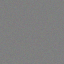

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image


# Define Diffusion Decoder Model
class DiffusionDecoder(nn.Module):
    def __init__(self, latent_dim, image_size):
        super(DiffusionDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, image_size * image_size * 3)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.sigmoid(x)
        x = x.view(-1, 3, image_size, image_size)
        return x

# Initialize Models
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_dim = 512
latent_dim = 512
image_size = 64


diffusion_decoder = DiffusionDecoder(latent_dim, image_size).to(device)

# Generate Latent Vector
def generate_latent(text_embedding):
    text_embedding = text_embedding.to(device)
    with torch.no_grad():
        latent = prior_model(text_embedding)
        latent = latent.squeeze(1)
    return latent

# Generate Image from Latent Vector
def generate_image(latent_vector):
    latent_vector = latent_vector.to(device)
    with torch.no_grad():
        generated_image = diffusion_decoder(latent_vector)
    return generated_image

# Convert Tensor to PIL Image
def tensor_to_pil(tensor):
    tensor = tensor.squeeze().cpu().detach().clamp(0, 1)
    array = tensor.permute(1, 2, 0).numpy()
    return Image.fromarray((array * 255).astype(np.uint8))


generated_image = generate_image(latent_vector)
generated_image_pil = tensor_to_pil(generated_image)
#generated_image_pil.show()
# Save the generated image to a file
image_path = '/tmp/generated_image.png'
generated_image_pil.save(image_path)

print(f"Image saved to {image_path}")


# Display the image in a Jupyter notebook
display(generated_image_pil)